<a href="https://colab.research.google.com/github/littlebiggeo/csdms-clinic-2020/blob/master/csdms_2020_hrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSDMS HRT Data-Model Integration Workshop
**Basic handling and analysis of raster data in Python**

Using the Southern San Luis Mountains as a test terrain

**First, let's set up the environment**

If on github, first click on the link "Open in Colab" to start running on Google's colab environment



We will be relying heavily on WhiteboxTools, an open source spatial analytics package developed by John Lindsay at the University of Guelph

https://jblindsay.github.io/ghrg/WhiteboxTools/index.html

![alt text](https://jblindsay.github.io/ghrg/img/WhiteboxToolsLogo_vert.svg)

Run the following code to install all necessary dependencies and clone a git folder with several useful items...

Do not proceed until you see Ready!


---





## Clone Git and install environment

In [1]:
try:
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/littlebiggeo/csdms-clinic-2020.git

  # Now install environment using tool
  !/bin/bash /content/csdms-clinic-2020/hrt/install_raster_tools.sh
 
except:
  pass

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"csdms-clinic-2020"))

Cloning into 'csdms-clinic-2020'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 239 (delta 1), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (239/239), 37.58 MiB | 20.13 MiB/s, done.
Resolving deltas: 100% (63/63), done.
(1) Install Whitebox via pip
(2) Install gdal via apt-get
(3) Install rasterio via pip
(4) Install earthpy via pip
(5) Install seaborn via pip
(6) Install pygeotools via pip
(7) Install google drive downloader via pip
(8) Install tifffile via pip
(9) Download CSDMS 2020 clinic github repository
(10) Ready!


## Import all necessary modules and setup inline graphics

In [2]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os, pkg_resources
from pygeotools.lib import iolib, warplib, geolib, timelib, malib
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rasterio as rio
import imageio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep
from rasterio.plot import show
from rasterio.mask import mask

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Transfer in DEM from google drive

In [5]:
#This is a downloader that allows you to import large files from Google Drive into the colab runtimes local disk space
#It is necessary for working 
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1mT2hCI7T3zVGEe7jVDz5xvoS83zoeVVj',
                                    dest_path='./csdms-clinic-2020/data/sanluis/dem1_sl.tif',
                                    unzip=False)

In [7]:
#Set our data directory to our new cloned Git and where we placed the DEM
data_dir = './csdms-clinic-2020/data/sanluis/'
print(os.listdir(data_dir))

['dem1_sl.tif', 'readme.md']


## Let's load some data!

In [9]:
#import whitebox to begin raster processing and manipulation
import whitebox
wbt = whitebox.WhiteboxTools()

# set whitebox working directory
wbt.set_working_dir(data_dir)
wbt.verbose = False
print(os.listdir(data_dir))

['dem1_sl.tif', 'readme.md']


In [29]:
#Open our DEM (in tif format) using rasterio and convert to a numpy array
with rio.open('/content/csdms-clinic-2020/data/sanluis/dem1_sl.tif') as src:
    # Convert / read the data into a numpy array
    # masked = True turns `nodata` values to nan
    dem1_sl_im = src.read(1, masked=True)
    
    # Create a spatial extent object using rio.plot.plotting
    spatial_extent = rio.plot.plotting_extent(src)

print("object shape:", dem1_sl_im.shape)
print("object type:", type(dem1_sl_im))

with rio.open('/content/csdms-clinic-2020/data/sanluis/dem1_sl.tif') as src:
    
    # Convert / read the data into a numpy array:
    dem1_sl_2 = src.read(1)

with rio.open('/content/csdms-clinic-2020/data/sanluis/dem1_sl.tif') as src:
    
    # Convert / read the data into a numpy array:
    dem1_sl_3 = src.read()

print("Array Shape Using read(1):", dem1_sl_2.shape)

# Notice that without the (1), your numpy array has a third dimension
print("Array Shape Using read():", dem1_sl_3.shape)

#Update our metadata for raster export


object shape: (3562, 6514)
object type: <class 'numpy.ma.core.MaskedArray'>
Array Shape Using read(1): (3562, 6514)
Array Shape Using read(): (1, 3562, 6514)


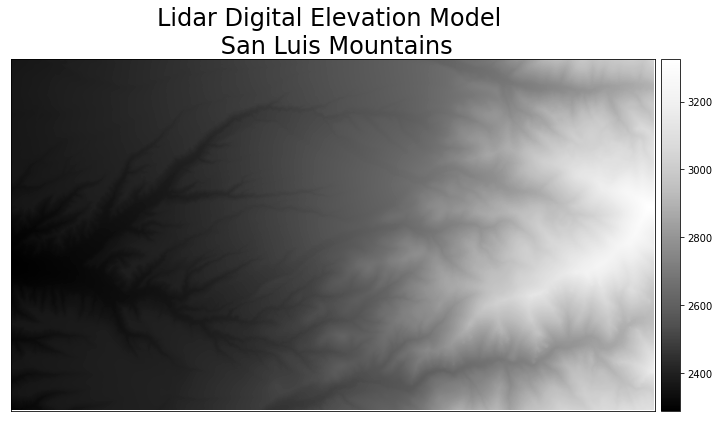

In [58]:
#plot our raster, which is a 1m lidar derived DEM from the San Luis Mountains
fig, ax = plt.subplots(figsize=(12, 10))
ep.plot_bands(dem1_sl_im,
              cmap='Greys_r',
              extent=spatial_extent,
              scale=False,
              ax=ax)
ax.set_title("Lidar Digital Elevation Model \n San Luis Mountains", 
             fontsize=24)
plt.show()

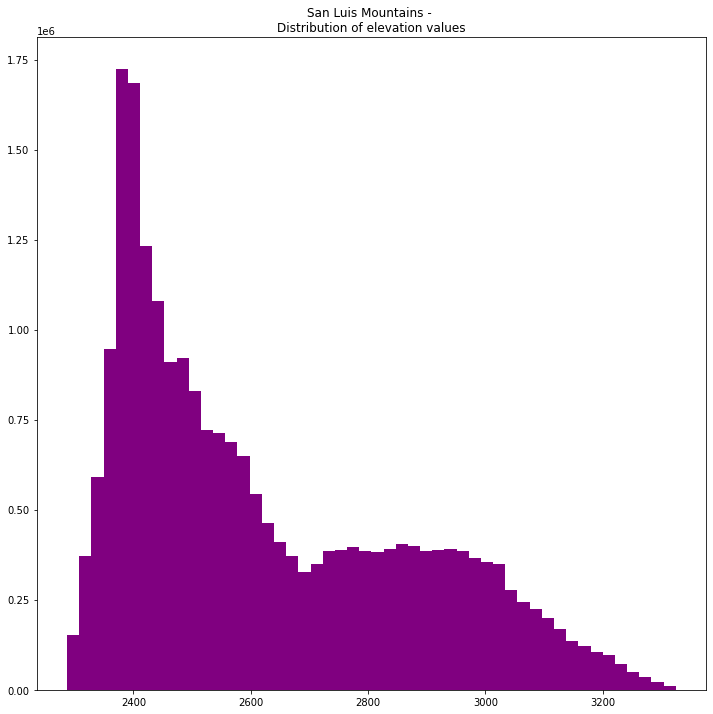

In [32]:
#Lets take a peek at the distribution of elevation values within this domain
# Plot histogram
ep.hist(dem1_sl_im[~dem1_sl_im.mask].ravel(),
        bins=50,
        title="San Luis Mountains - \nDistribution of elevation values")
plt.show()

## Raster calculations

In [66]:
#Set our data directory to our new cloned Git and where we placed the DEM
data_dir = '/content/csdms-clinic-2020/data/sanluis/'
print(os.listdir(data_dir))

#set whitebox working directory
wbt.set_working_dir(data_dir)

#Create a hillshade to better visualize our DEM
wbt.hillshade("dem1_sl.tif", "dem1_sl_315_30.tif", 315, 30)

#Read hillshade tiff to array for easier plotting
hillshade = imageio.imread(os.path.join(data_dir, 'dem1_sl_315_30.tif'))


['dem1_sl.tif', 'readme.md', 'dem1_sl_315_30.tif']


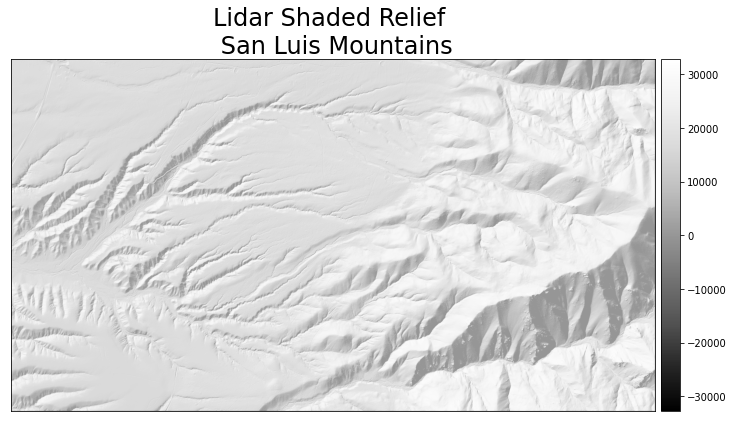

In [68]:
#Plot our new hillshade!
fig, ax = plt.subplots(figsize=(12, 10))
ep.plot_bands(hillshade,
              cmap='Greys_r',
              extent=spatial_extent,
              scale=False,
              ax=ax)
ax.set_title("Lidar Shaded Relief \n San Luis Mountains", 
             fontsize=24)
plt.show()

## Detrending the DTM

In [69]:
#The hillshade shows us the beautiful channel structure of this basin: lets see if we can emphasise it further by detrending the DEM by a polynomial
#Create second order polynomial trend surface
wbt.trend_surface("dem1_sl.tif", "dem1_sl_trend_2.tif", order=2)

#Read trend surface .tif into array
trend_surface = imageio.imread(os.path.join(data_dir, 'dem1_sl_trend_2.tif'))

#Subtract trend surface from DEM
wbt.subtract("dem1_sl.tif", "dem1_sl_trend_2.tif", "detrended_dem1.tif")

#Read detrended DEM into array
detrended = imageio.imread(os.path.join(data_dir, 'detrended_dem1.tif'))

tcmalloc: large alloc 1113260032 bytes == 0x5651cdf60000 @  0x7faac2a02001 0x56519ffdea77 0x56519f982512 0x5651a03b47d9 0x5651a03b1daf 0x5651a00a1183 0x5651a0488803 0x5651a049135a 0x5651a0489250 0x5651a03b58f2 0x7faac1dbab97 0x56519f7ead6a


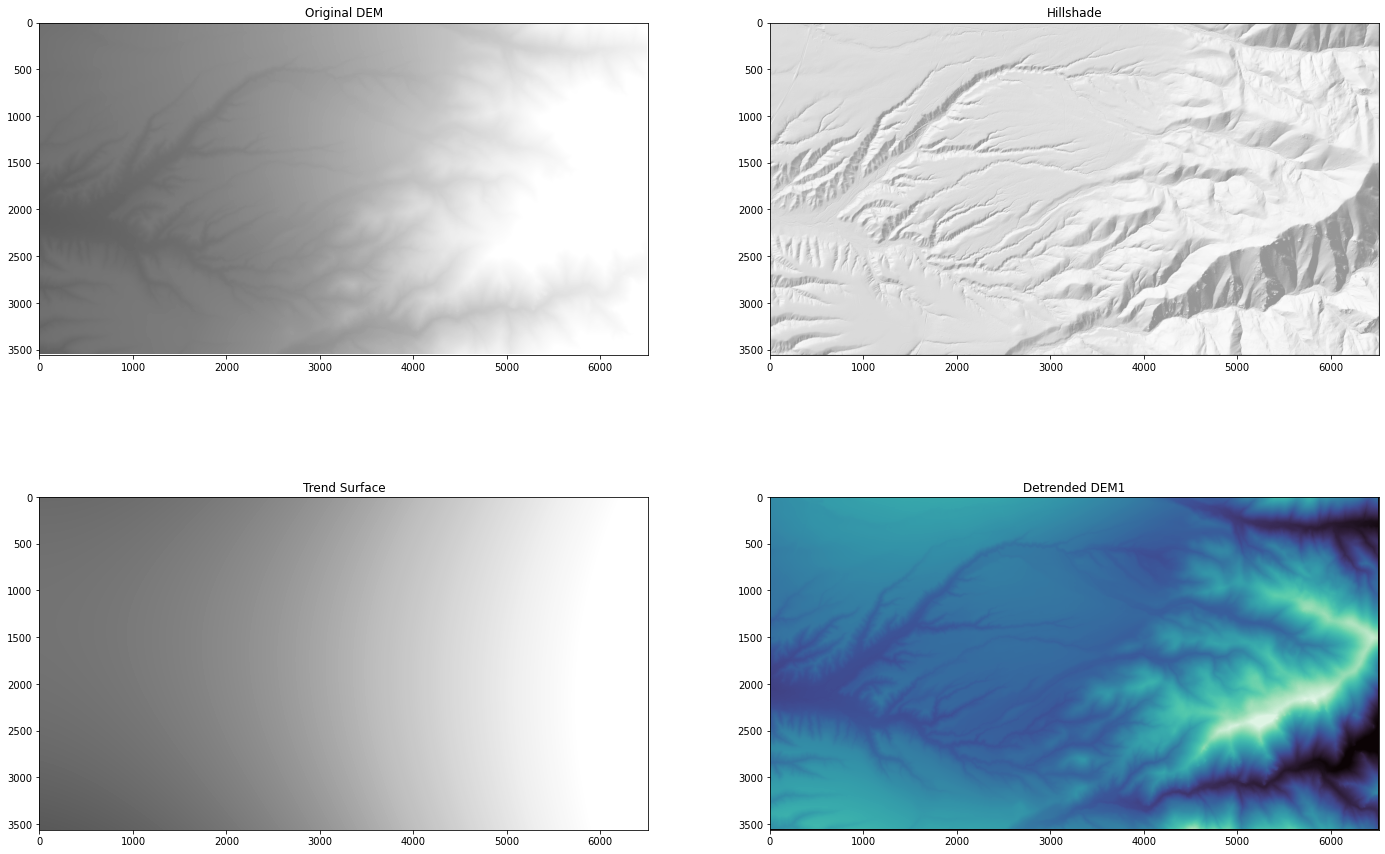

In [74]:
#Lets see how the detrended DEM compares to the original and the hillshade
fig=plt.figure(figsize=(24,16))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Original DEM')
plt.imshow(dem1_sl_im, cmap='Greys_r', vmin=2000, vmax=3000)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Hillshade')
plt.imshow(hillshade, cmap='Greys_r')

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Trend Surface')
plt.imshow(trend_surface,cmap='Greys_r', vmin=2000, vmax=3000)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Detrended DEM1')
plt.imshow(detrended,cmap='mako', vmin=-200, vmax=200)

plt.show()

## Channel network analysis
While looking at the DEM is fun, it's time to see about actually running some flow routing schemes over it and seeing what the structure of the channel network looks like.

The workflow for channel network extraction is fairly straightforward: 1) Create a depression "breached" DEM. 2) Calculate flow direction from one cell to the next. 3) Calculate flow accumulation, or the sum of successive cells that preferentially flow into each other based on the flow direction. 4) This is our stream network! A stream is delineated based on a chosen accumulation threshold, which is relatively arbitrary

In [75]:
#First we calculate our smoothed raster, our depression filled raster, and then flow accumulation
#We will calculate both Dinf and D8 flow accumulation
wbt.feature_preserving_smoothing("dem1_sl.tif", "smoothed.tif", filter=3)
wbt.breach_depressions("smoothed.tif", "breached.tif")
wbt.d_inf_flow_accumulation("breached.tif", "flow_accum.tif")
wbt.d8_flow_accumulation("breached.tif", "flow_accum_d8.tif")

0

In [0]:
#Read the resulting tiffs into arrays for easier plotting
original = imageio.imread(os.path.join(data_dir, 'dem1_sl.tif'))
smoothed = imageio.imread(os.path.join(data_dir, 'smoothed.tif'))
breached = imageio.imread(os.path.join(data_dir, 'breached.tif'))
flow_accum = imageio.imread(os.path.join(data_dir, 'flow_accum.tif'))
flow_accum_d8 = imageio.imread(os.path.join(data_dir, 'flow_accum_d8.tif'))

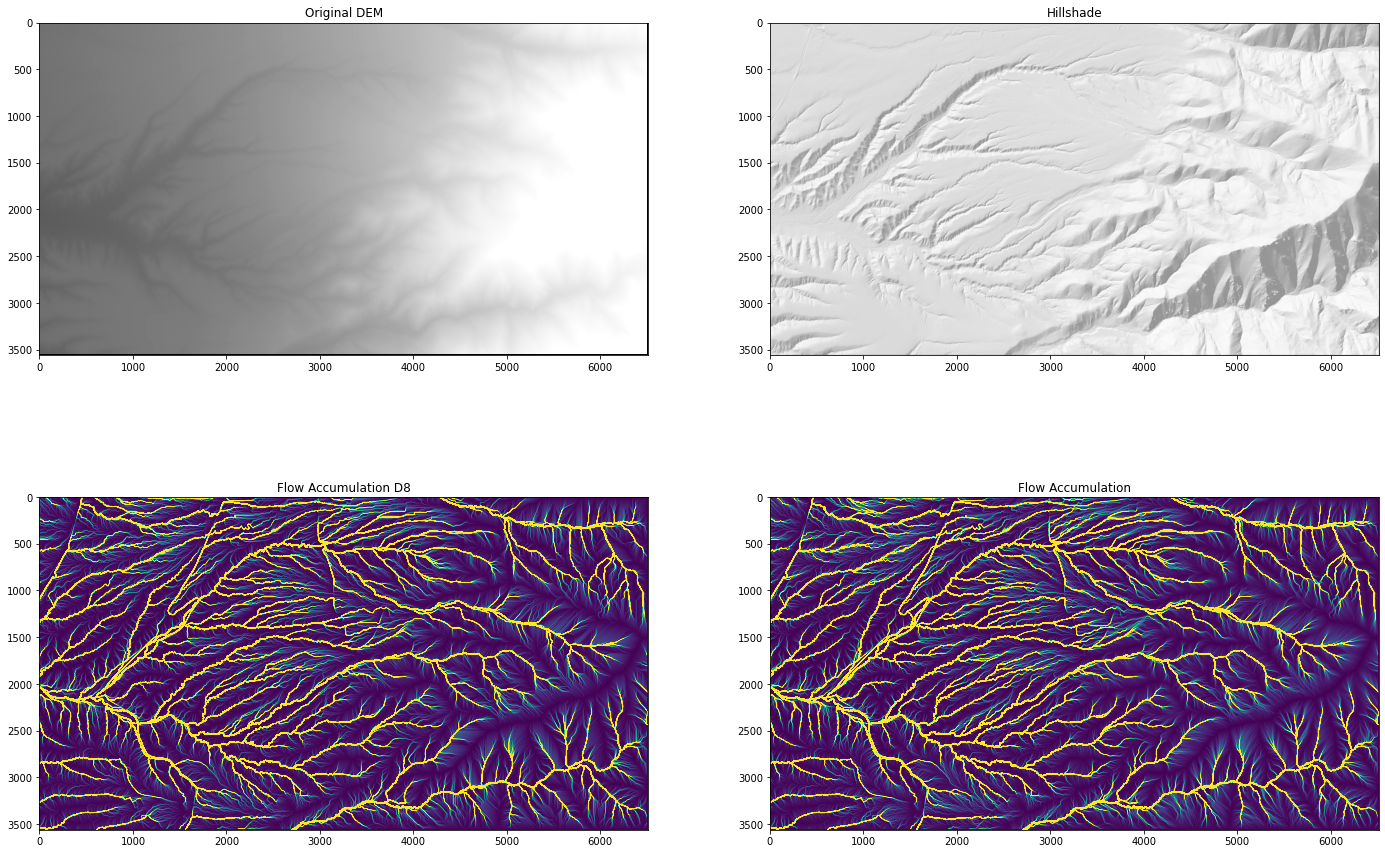

In [81]:
#Lets take a look!
fig=plt.figure(figsize=(24,16))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Original DEM')
plt.imshow(original, vmin=2000, vmax=3000, cmap='Greys_r')

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Hillshade')
plt.imshow(hillshade, cmap = 'Greys_r')

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Flow Accumulation D8')
plt.imshow(flow_accum_d8, vmin=0, vmax=1000)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Flow Accumulation')
plt.imshow(flow_accum, vmin=0, vmax=1000)

plt.show()

## Converting stream raster to vector

## Watershed delineation and statistics

## Comparison with GeoNet skeleton

## Change Detection post Hurricane Harvey

In [0]:
#This is a downloader that allows you to import large files from Google Drive into the colab runtimes local disk space
#Lets get the Cypress Creek Data
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1tQKolzAQQM8ZEYG18dJ8Yk8Kl6FZrDvu',
                                    dest_path='./csdms-clinic-2020/data/hgac_3m.tif',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='1Ay7cXPcOOR1Zao5W_EjUWsIm4SK5DJcj',
                                    dest_path='./csdms-clinic-2020/data/dem3_cy_creek.tif',
                                    unzip=False)

In [89]:
#Set our data directory to our new cloned Git and where we placed the DEM
data_dir = './csdms-clinic-2020/data/'
print(os.listdir(data_dir))

['dem3_cy_creek.tif', 'hgac_3m.tif']


In [87]:
#Open our DEM (in tif format) using rasterio and convert to a numpy array
with rio.open('/content/csdms-clinic-2020/data/dem3_cy_creek.tif') as src:
    # Convert / read the data into a numpy array
    # masked = True turns `nodata` values to nan
    dem3_cy_im = src.read(1, masked=True)
    
    # Create a spatial extent object using rio.plot.plotting
    spatial_extent = rio.plot.plotting_extent(src)

print("object shape:", dem3_cy_im.shape)
print("object type:", type(dem3_cy_im))

with rio.open('./content/csdms-clinic-2020/data/dem3_cy_creek.tif') as src:
    
    # Convert / read the data into a numpy array:
    dem3_cy_2 = src.read(1)

with rio.open('/content/csdms-clinic-2020/data/dem3_cy_creek.tif') as src:
    
    # Convert / read the data into a numpy array:
    dem3_cy_3 = src.read()

print("Array Shape Using read(1):", dem3_cy_2.shape)

# Notice that without the (1), your numpy array has a third dimension
print("Array Shape Using read():", dem3_cy_3.shape)

#Update our metadata for raster export


RasterioIOError: ignored